# How to use *Quasar Factor Analysis* to infer quasar continuum?

Below we will show how to use *Quasar Factor Analysis* to infer quasar contiuum for single spectrum.

In [1]:
import numpy as np
import torch
from warnings import filterwarnings
from QFA.model import QFA
from matplotlib import pyplot as plt
%matplotlib inline

filterwarnings("ignore")
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rcParams["mathtext.fontset"] = 'stix'

### Let's take a brief look at the spectrum first!

In [2]:
# define wavelength grid
loglam_min, loglam_max, loglam_delta = np.log10(1030.), np.log10(1600.), 1e-4
loglam = np.arange(loglam_min, loglam_max, loglam_delta)
wav_grid = 10**loglam

data = np.load("../data/spec-4321-55504-0114.npz")
flux, error, z, snr = data['flux'], data['error'], float(data['z']), float(data['snr'])
mask = (flux!=-999.)&(error!=-999.)

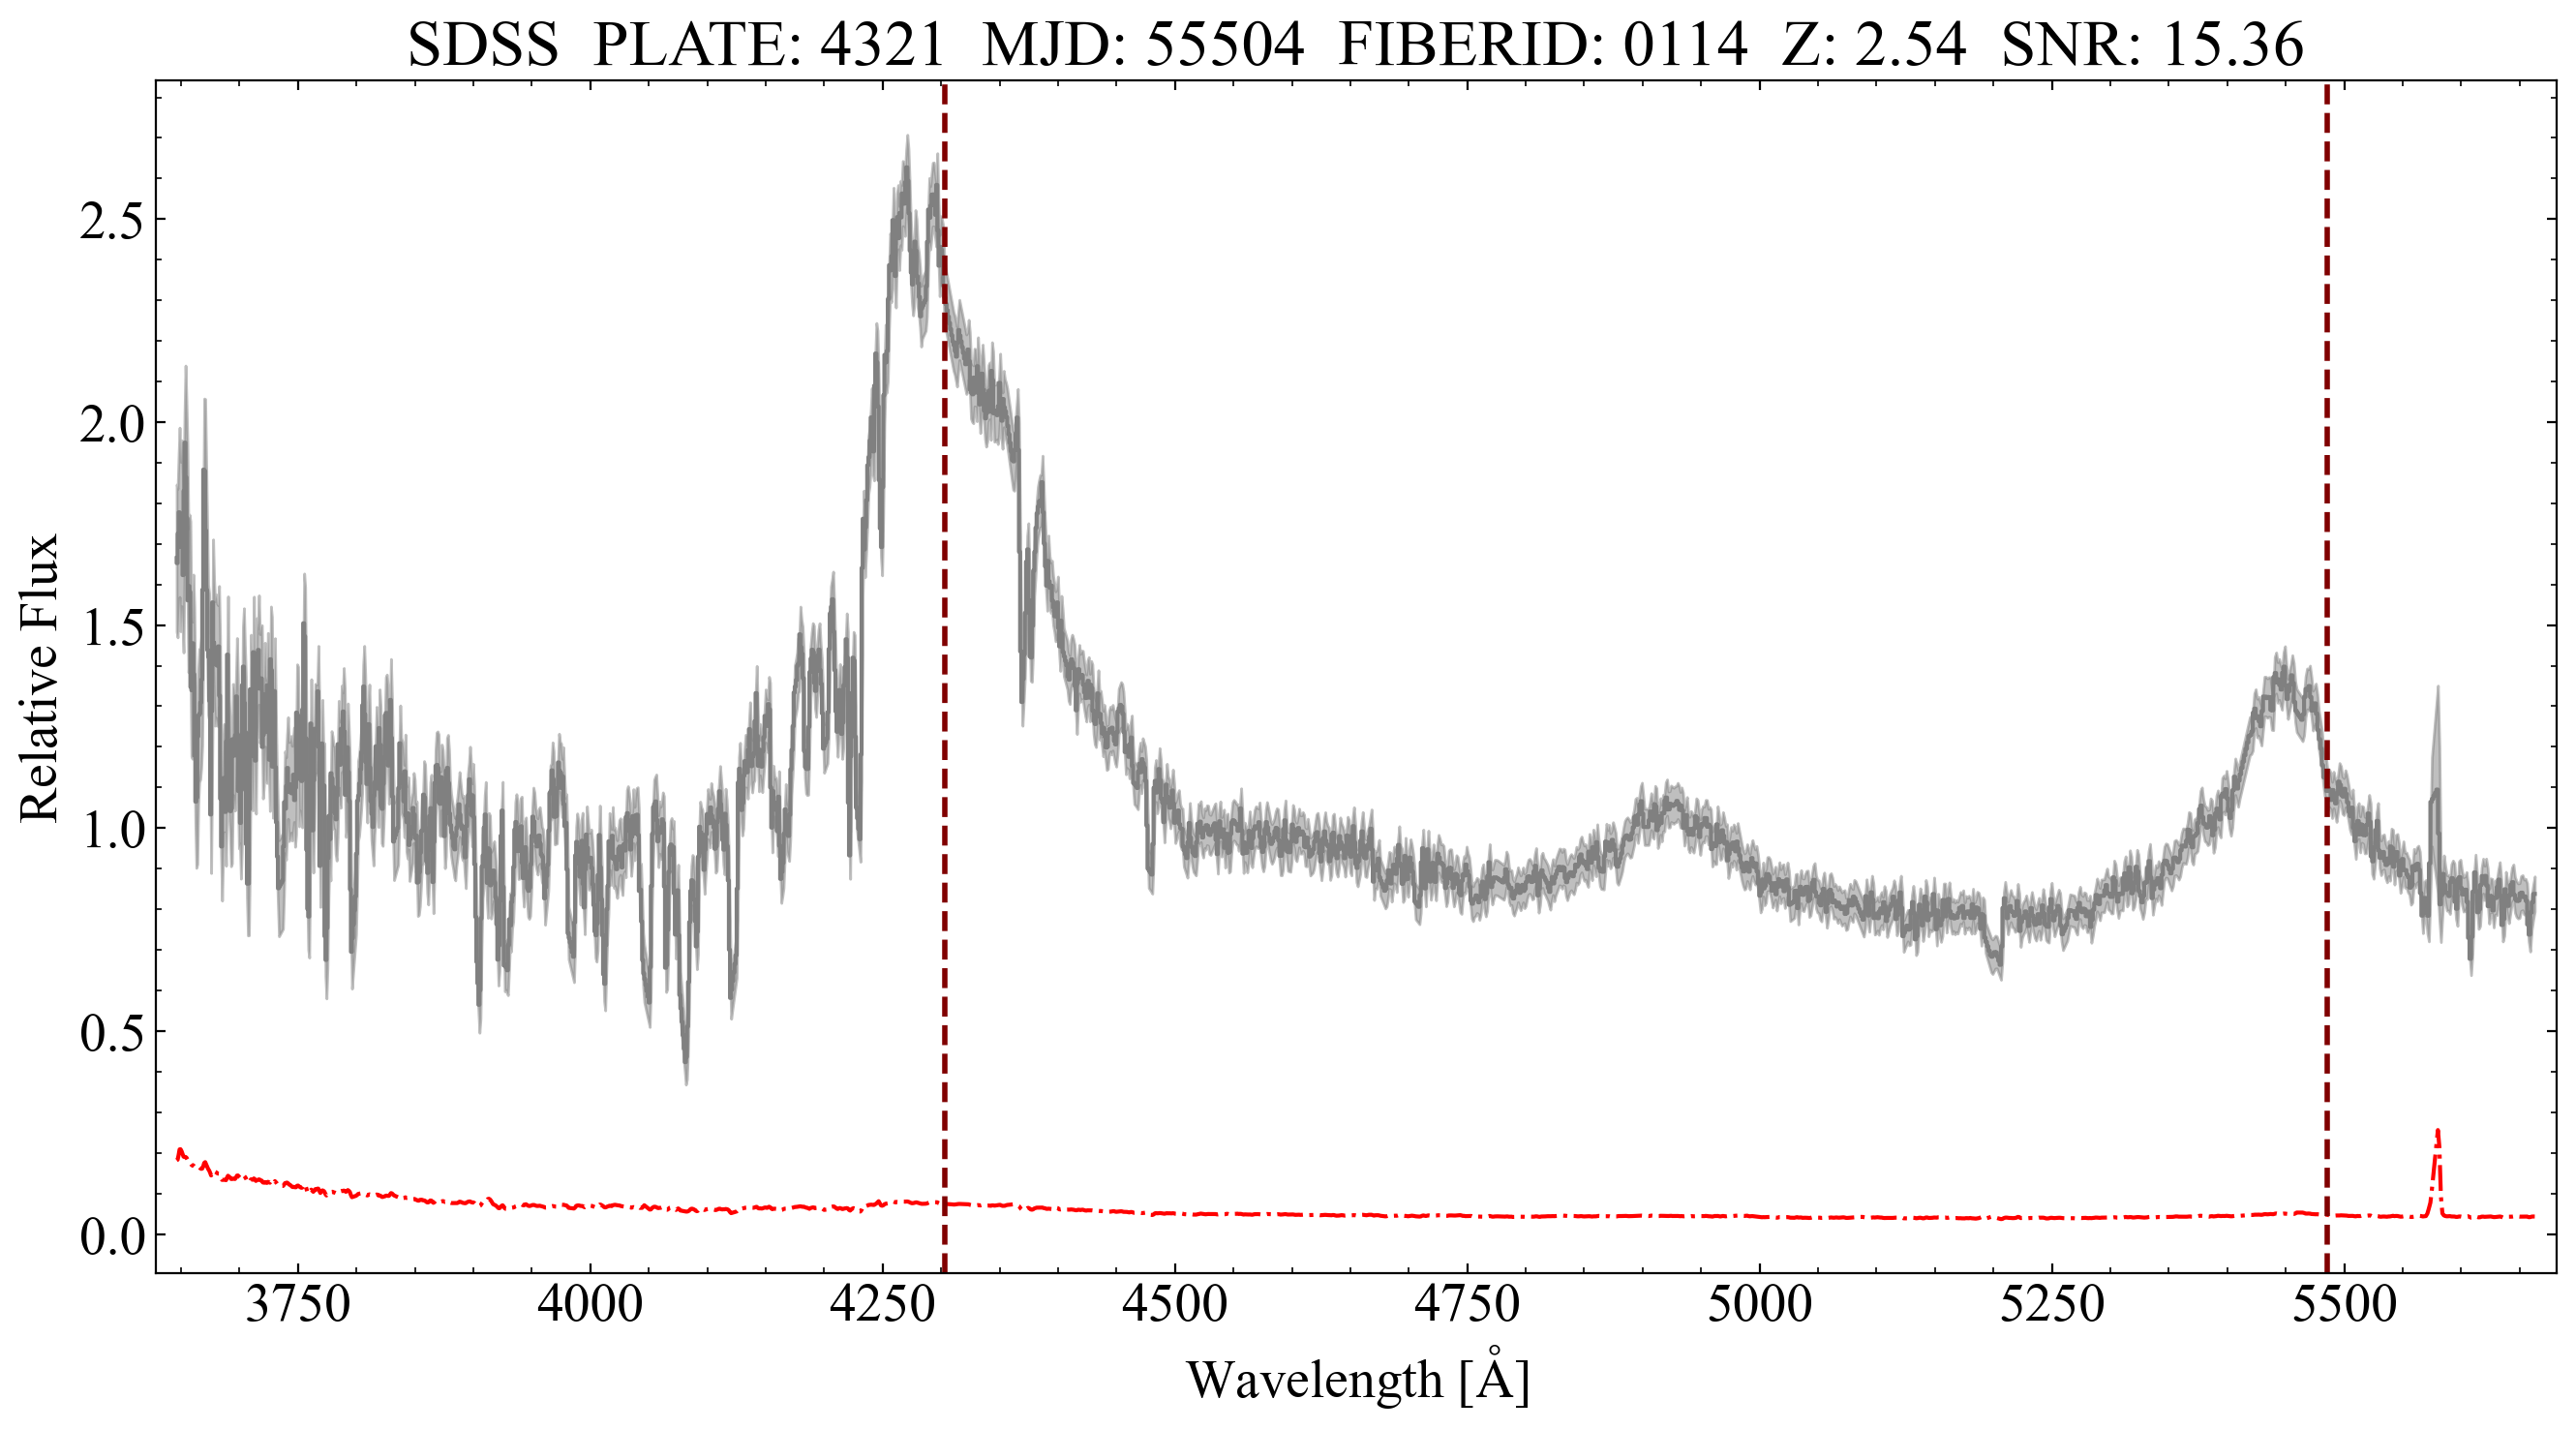

In [3]:
_ = plt.figure(figsize=(16, 8), dpi=200)
_ = plt.step(wav_grid*(1+z), flux, color='gray')
_ = plt.plot(wav_grid*(1+z), error, color='red', linestyle='-.')
_ = plt.fill_between(wav_grid*(1+z), flux+error, flux-error, color='grey', alpha=0.5)
_ = plt.tick_params(which='both', left=True, right=True, top=True, bottom=True, direction='in')
_ = plt.minorticks_on()
_ = plt.xlim(1025.*(1+z), 1605.*(1+z))
_ = plt.xlabel('Wavelength [$\mathrm{\AA}$]')
_ = plt.ylabel('Relative Flux')
_ = plt.axvline(x=1215.67*(1+z), color='maroon', linestyle='--', linewidth=2)
_ = plt.axvline(x=1549.5*(1+z), color='maroon', linestyle='--', linewidth=2)
_ = plt.title(f"SDSS  PLATE: 4321  MJD: 55504  FIBERID: 0114  Z: {z:.2f}  SNR: {snr:.2f}")

### Statistical background for QFA to perform continuum inference

Assume a quasar spectrum $(\lambda, z, \mathrm{S}, \sigma_\epsilon)$, in which $\lambda$ is the wavelength grid, $z$ is the redshift, $\mathrm{S}$ is the relative flux normalized at rest-frame wavelength $1280\mathrm{\AA}$ and $\sigma_\epsilon$ is the flux uncertainty array.

In `train.ipynb`, we have displayed how to use a set of quasar spectra $\mathcal{D}=\{(\lambda^i, z^i, \mathrm{S}^i, \sigma^i_\epsilon)|i=1,2,\dots,\mathrm{N}_\mathrm{spec}\}$ to get the optimal model $\mathcal{M}^*$, which satisfies

$$
\mathcal{M}^* = \mathrm{arg\,max}\,\,\mathrm{P}(\mathcal{M}|\mathcal{D})
$$

Now with a well trained model $\mathcal{M}^*$, we hope to derive the posterior distribution of the hidden factor $\mathbf{h}$ as:

$$
\mathrm{P}(\mathbf{h}|\lambda,z,\mathrm{S},\sigma_\epsilon,\mathcal{M}^*) \propto \mathrm{P}(\mathrm{S}|\lambda, \mathbf{h},\sigma_\epsilon,\mathcal{M}^*)\,\mathrm{P}(\mathbf{h})
$$

The posterior distribution of quasar continuum $\mathbf{C}$ can be easiy accessed through $\mathbf{C}=\mu+F\mathbf{h}$

### Let's give it a try!

In [14]:
Nb, Nr, Nh = np.sum(wav_grid<1215.67), np.sum(wav_grid>=1215.67), 8
device = torch.device('cpu')
model = QFA(Nb, Nr, Nh, device)
model.load_from_npz('../data/model_parameters.npz')
model_parameters = np.load('../data/model_parameters.npz')

In [7]:
# estimate from QFA
flux = torch.tensor(flux, dtype=torch.float).to(device)
error = torch.tensor(error, dtype=torch.float).to(device)
mask = torch.tensor(mask, dtype=bool).to(device)
zabs = torch.tensor(wav_grid[:Nb]*(1+z)/1215.67-1, dtype=torch.float)
ll, hmean, hcov, cont, uncertainty = model.prediction_for_single_spectra(flux, error, zabs, mask)
hmean, hcov, cont, uncertainty = hmean.numpy(), hcov.numpy(), cont.numpy(), uncertainty.numpy()

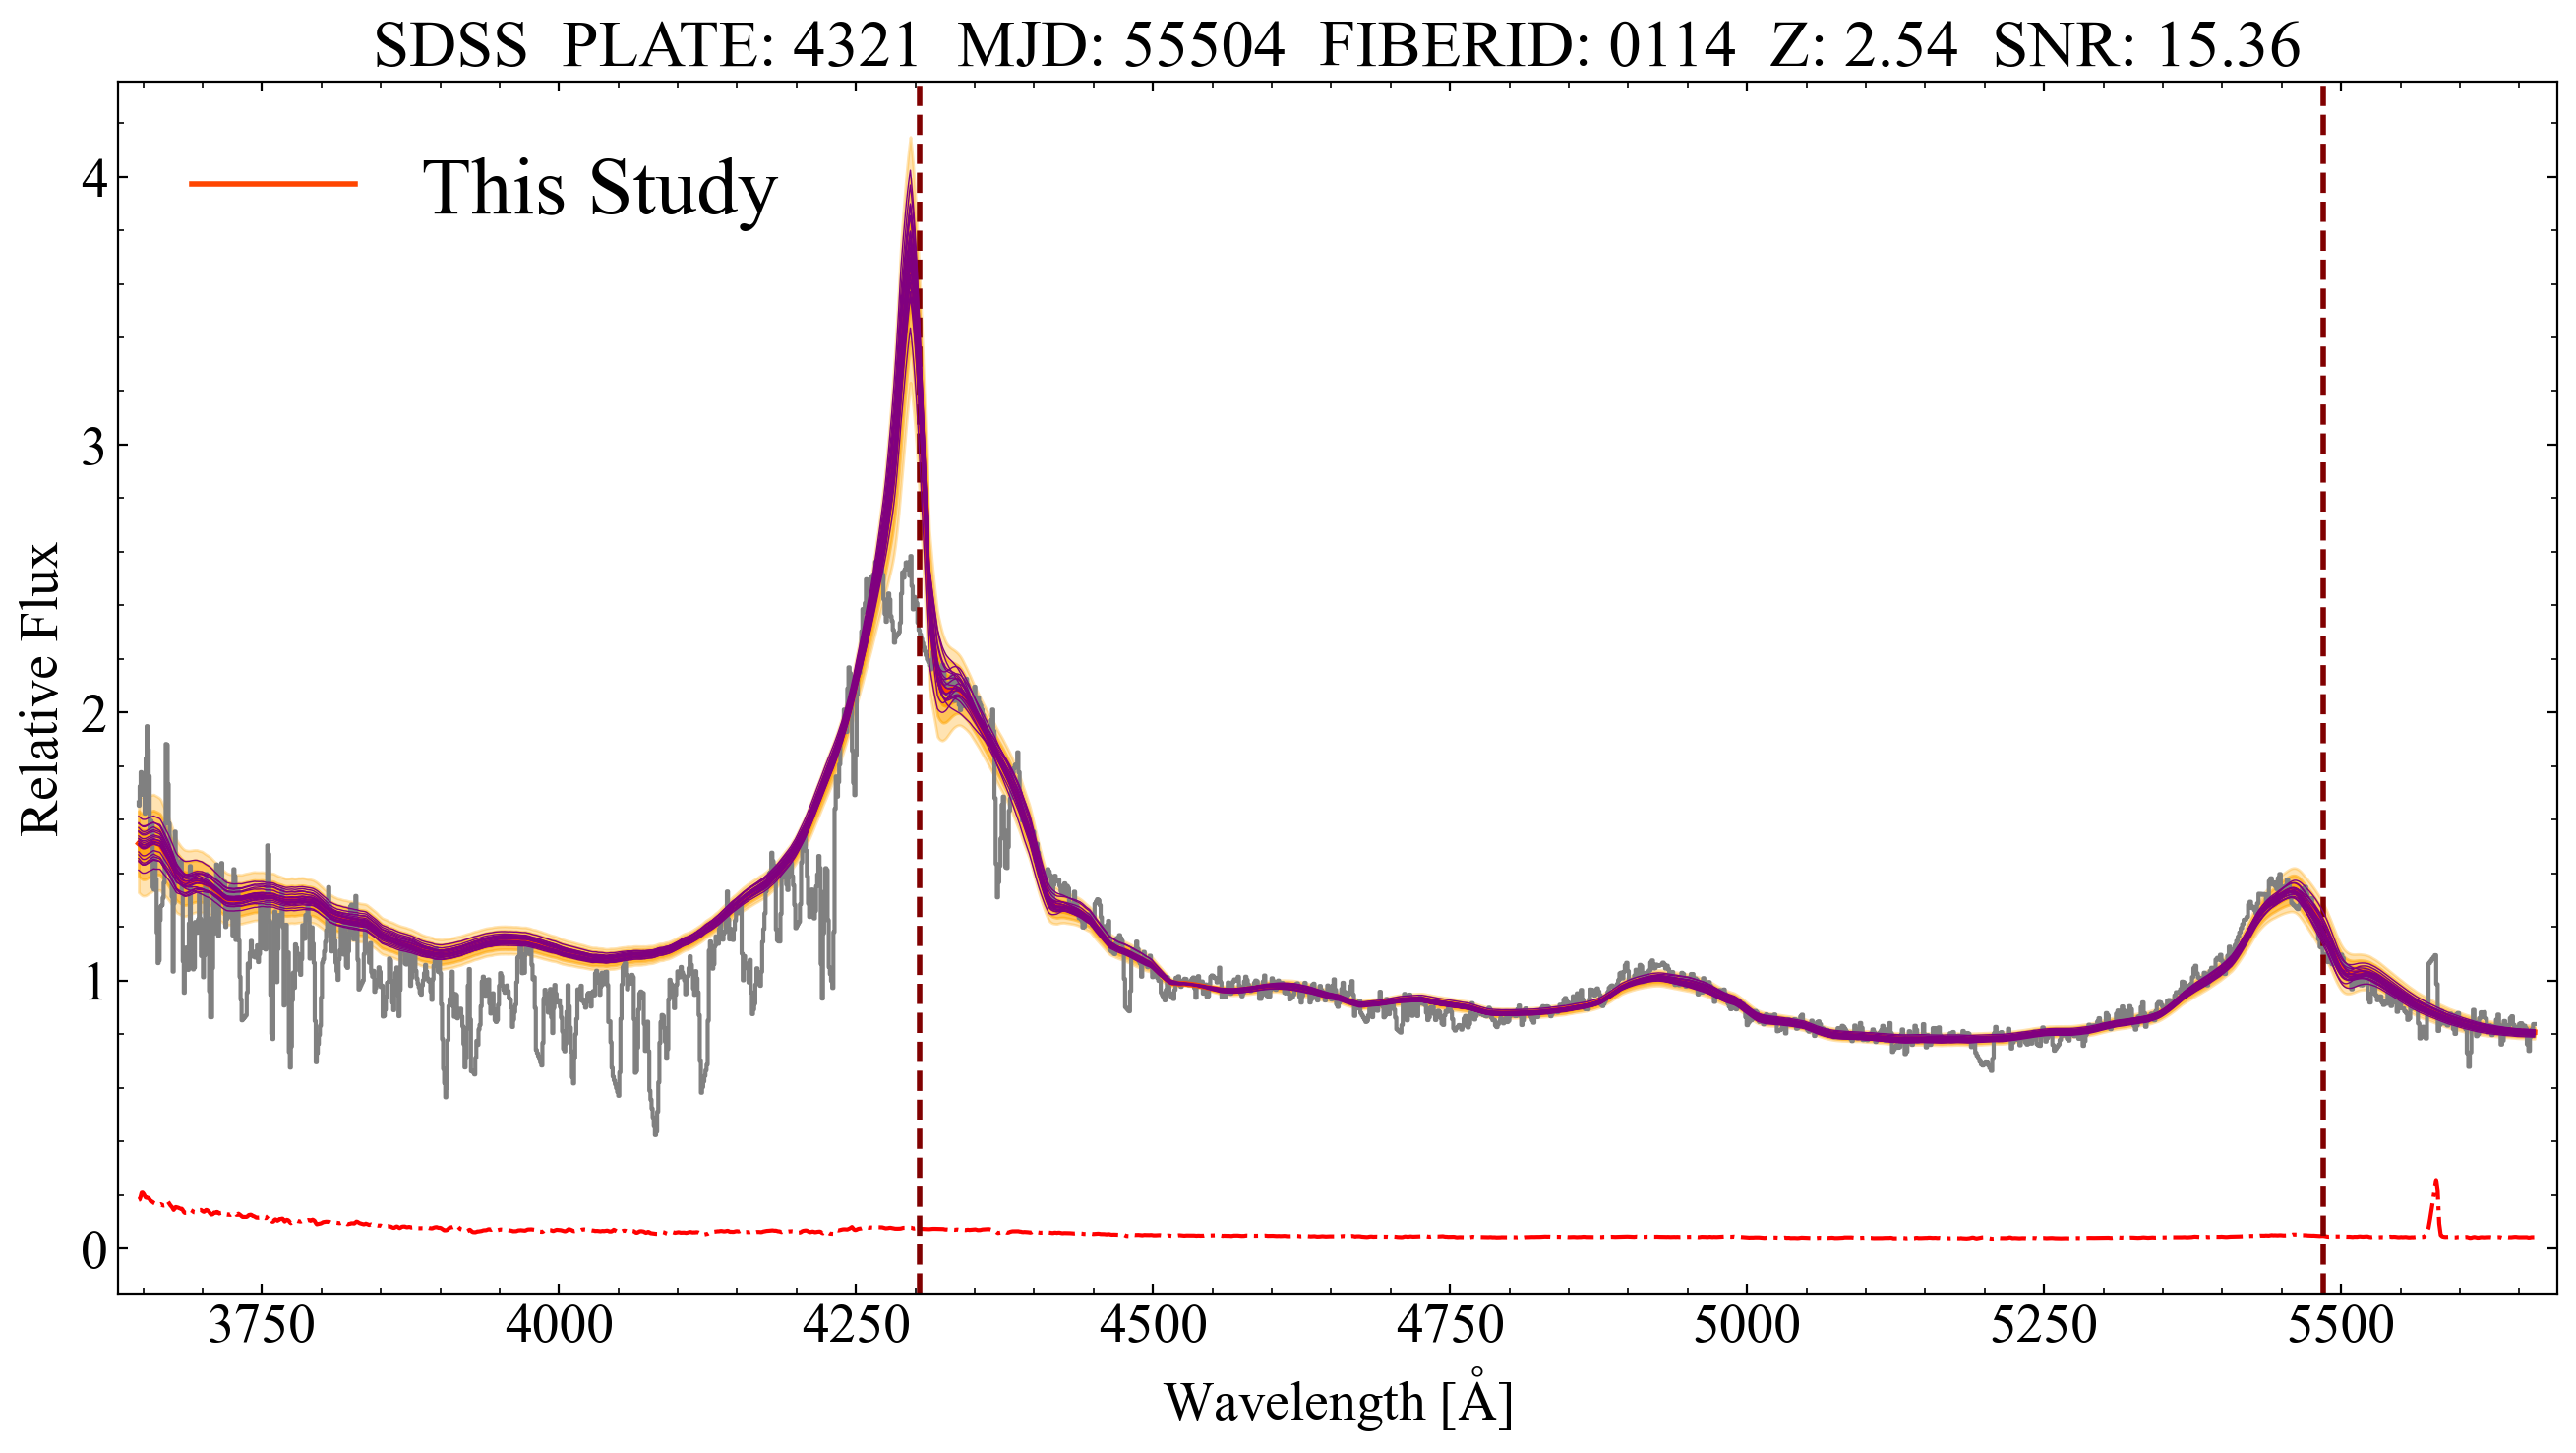

In [18]:
_ = plt.figure(figsize=(16, 8), dpi=200)
_ = plt.step(wav_grid*(1+z), flux, color='gray')
_ = plt.plot(wav_grid*(1+z), cont, color='orangered', linestyle='-', linewidth=2, label='This Study')
_ = plt.fill_between(wav_grid*(1+z), cont+uncertainty, cont-uncertainty, color='#FF8C00', alpha=0.7)
_ = plt.fill_between(wav_grid*(1+z), cont+2*uncertainty, cont-2*uncertainty, color='#FFA500', alpha=0.5)
_ = plt.fill_between(wav_grid*(1+z), cont+3*uncertainty, cont-3*uncertainty, color='#FFA500', alpha=0.3)
_ = plt.plot(wav_grid*(1+z), error, color='red', linestyle='-.')
_ = plt.tick_params(which='both', left=True, right=True, top=True, bottom=True, direction='in')
_ = plt.minorticks_on()
_ = plt.xlim(1025.*(1+z), 1605.*(1+z))
_ = plt.xlabel('Wavelength [$\mathrm{\AA}$]')
_ = plt.ylabel('Relative Flux')
_ = plt.axvline(x=1215.67*(1+z), color='maroon', linestyle='--', linewidth=2)
_ = plt.axvline(x=1549.5*(1+z), color='maroon', linestyle='--', linewidth=2)
_ = plt.title(f"SDSS  PLATE: 4321  MJD: 55504  FIBERID: 0114  Z: {z:.2f}  SNR: {snr:.2f}")
_ = plt.legend(loc='best', frameon=False, fontsize=30)

# sample from posterior distribution
for _ in range(20):
    hsample = np.random.multivariate_normal(mean=hmean, cov=hcov)
    sample_cont = model_parameters['mu'] + model_parameters['F']@hsample
    _ = plt.plot(wav_grid*(1+z), sample_cont, linewidth=0.5, color='purple')

We can see QFA gives reasonable continuum prediction & uncertainty quantification!